In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip -q install torch_geometric scikit-learn

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import degree

from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

BASE = Path("/content/drive/MyDrive/biolip_gnn")
LABELED_DIR = BASE / "graphs_labeled_v3"
OUT_DIR = BASE / "out"
OUT_DIR.mkdir(exist_ok=True)

npz_files = sorted(LABELED_DIR.glob("*.npz"))
print("Labeled graphs:", len(npz_files))

def load_npz(path: Path) -> dict:
    z = np.load(path, allow_pickle=True)
    return {k: z[k] for k in z.files}

raw_graphs = [load_npz(p) for p in npz_files]
print("Loaded graphs:", len(raw_graphs))
print("Example files keys:", raw_graphs[0].keys())


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00
Labeled graphs: 50
Loaded graphs: 50
Example files keys: dict_keys(['pdb_id', 'chain', 'coords', 'x_idx', 'edge_index', 'edge_dist', 'resseq', 'n_nodes', 'n_edges', 'y', 'label_mode'])


In [3]:
# build node features: degree + mean neighbour distance

def compute_degree(edge_index: torch.Tensor, n_nodes: int) -> torch.Tensor:
  deg = degree(edge_index[0], num_nodes = n_nodes).view(-1,1).float()
  return (deg - deg.mean()) / (deg.std() + 1e-9)

def compute_mean_neighbour_dist(edge_index: torch.Tensor, edge_dist: torch.Tensor, n_nodes: int):
  """
  edge_dist: (E:1), distances for each edge.
  We compute mean distance per node using outgoing edges edfge_index[0] -> edge_index[1]
  """
  src = edge_index[0]
  dist = edge_dist.view(-1)

  sum_dist = torch.zeros(n_nodes, dtype=torch.float)
  cnt = torch.zeros(n_nodes, dtype = torch.float)

  sum_dist.scatter_add_(0, src, dist)
  cnt.scatter_add_(0, src, torch.ones_like(dist))

  mean = (sum_dist / (cnt + 1e+9)).view(-1,1)

  #normalize within graph
  return (mean - mean.mean()) / (mean.std() + 1e-9)



In [4]:
# creating 3 datasets (base, + degree, +degree+meanDist)

def to_pyg(graph_dict: dict, mode: str="base") -> Data:
  """
  mode:
    base: AA only
    deg: AA + degree
    deg_meandist: AA + degree + mean neighbor distance
  """

  x_idx = torch.tensor(graph_dict["x_idx"], dtype=torch.long)
  edge_index = torch.tensor(graph_dict["edge_index"], dtype= torch.long)
  y = torch.tensor(graph_dict["y"], dtype=torch.long)

  # edge distances
  if "edge_dist" in graph_dict:
    edge_attr = torch.tensor(graph_dict["edge_dist"], dtype=torch.float).view(-1,1)

  n_nodes = x_idx.numel()
  x = x_idx.view(-1,1)

  if mode in ["deg", "deg_meandist"]:
    deg = compute_degree(edge_index, n_nodes)
    x = torch.cat([x, deg], dim = 1)

  if mode == "deg_meandist":
    if edge_attr is None:
      raise ValueError("edge_dist missing in graph; cannot compute meanDist.")
    md = compute_mean_neighbour_dist(edge_index, edge_attr, n_nodes)
    x = torch.cat([x, md], dim = 1)

  d = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
  d.pdb_id = str(graph_dict.get("pdb_id",""))
  d.chain = str(graph_dict.get("chain"))
  return d

dataset_base = [to_pyg(g, mode="base") for g in raw_graphs]
dataset_deg = [to_pyg(g, mode="deg") for g in raw_graphs]
dataset_dm = [to_pyg(g, mode="deg_meandist") for g in raw_graphs]

print("Shapes:")
print(" base x:", dataset_base[0].x.shape)
print(" deg  x:", dataset_deg[0].x.shape)
print(" dm   x:", dataset_dm[0].x.shape)



Shapes:
 base x: torch.Size([387, 1])
 deg  x: torch.Size([387, 2])
 dm   x: torch.Size([387, 3])


In [12]:
# models for each feature nodes

class SAGE_NodeClassifier(nn.Module):
    def __init__(self, num_aa=21, emb_dim=32, hidden=64, extra_feats=0):
        super().__init__()
        self.emb = nn.Embedding(num_aa, emb_dim)
        in_dim = emb_dim + extra_feats

        self.conv1 = SAGEConv(in_dim, hidden)
        self.conv2 = SAGEConv(hidden, hidden)
        self.lin1  = nn.Linear(hidden, hidden)
        self.lin2  = nn.Linear(hidden, 1)

    def forward(self, data):
        aa_idx = data.x[:, 0].long()
        h = self.emb(aa_idx)

        if data.x.size(1) > 1:
            extras = data.x[:, 1:].float()
            h = torch.cat([h, extras], dim=1)

        h = F.relu(self.conv1(h, data.edge_index))
        h = F.relu(self.conv2(h, data.edge_index))
        h = F.relu(self.lin1(h))
        return self.lin2(h).squeeze(-1)


In [16]:
@torch.no_grad()
def collect_probs_and_labels(model, loader, device):
  model.eval()
  all_probs, all_y = [], []
  for batch in loader:
    batch = batch.to(device)
    logits = model(batch)
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    y = batch.y.detach().cpu().numpy()
    all_probs.append(probs)
    all_y.append(y)
  return np.concatenate(all_probs), np.concatenate(all_y)

def best_threshold_by_f1(probs, y_true):
  ap = float(average_precision_score(y_true, probs))
  prec, rec, thr = precision_recall_curve(y_true, probs)
  f1 = (2*prec[:-1]*rec[:-1]) / (prec[:-1]+rec[:-1] + 1e-9)
  best_i = int(np.argmax(f1))
  return {
      "auprc": ap,
      "best_thr": float(f1[best_i]),
      "best_f1": float(thr[best_i]),
      "best_precision": float(prec[best_i]),
      "best_recall": float(rec[best_i]),
      "prec_curve": prec,
      "rec_curve": rec
  }

def metrics_at_threshold(probs, y_true, thr):
  y_pred = (probs >= thr).astype(int)
  tp = int(((y_pred==1) & (y_true==1)).sum())
  fp = int(((y_pred==1) & (y_true==0)).sum())
  fn = int(((y_pred==0) & (y_true==1)).sum())
  precision = tp / (tp + fp + 1e-9)
  recall = tp / (tp + fn + 1e-9)
  f1 = (2 * precision * recall) / (precision + recall + 1e-9)
  ap = float(average_precision_score(y_true, probs))
  return ap, precision, recall, f1


In [17]:
# train + evaluate function (with class imbalance handling)

import random

def split_dataset(ds, seed = 42):
  ds = ds.copy()
  random.Random(seed).shuffle(ds)
  n = len(ds)
  n_train = int(0.7*n)
  n_val = int(0.15*n)
  return ds[:n_train], ds[n_train:n_train+n_val], ds[n_train+n_val:]

def pos_weight_from_train(train_set):
  pos = sum(int(d.y.sum()) for d in train_set)
  tot = sum(int(d.y.numel()) for d in train_set)
  neg = tot - pos
  return torch.tensor([neg / max(pos, 1)], dtype=torch.float)

def train_and_eval(ds, extra_feats, seed=42, epochs=10):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  train_set, val_set, test_set = split_dataset(ds, seed=seed)

  model = SAGE_NodeClassifier(extra_feats=extra_feats).to(device)

  train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
  val_loader   = DataLoader(val_set, batch_size=4, shuffle=False)
  test_loader  = DataLoader(test_set, batch_size=4, shuffle=False)

  pw = pos_weight_from_train(train_set).to(device)
  crit = nn.BCEWithLogitsLoss(pos_weight=pw)
  opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

  # train
  model.train()
  for _ in range(epochs):
    for batch in train_loader:
      batch = batch.to(device)
      logits = model(batch)
      loss = crit(logits, batch.y.float())
      opt.zero_grad()
      loss.backward()
      opt.step()

  # tune threshold on val
  val_probs, val_y = collect_probs_and_labels(model, val_loader, device)
  val_best = best_threshold_by_f1(val_probs, val_y)

  # test eval at tuned threshold
  test_probs, test_y = collect_probs_and_labels(model, test_loader, device)
  test_ap, test_p, test_r, test_f1 = metrics_at_threshold(test_probs, test_y, val_best["best_thr"])

  return {
    "val_auprc": val_best["auprc"],
    "val_best_thr": val_best["best_thr"],
    "val_f1": val_best["best_f1"],
    "test_auprc": test_ap,
    "test_precision": test_p,
    "test_recall": test_r,
    "test_f1": test_f1
    }

In [18]:
seeds = [1, 42, 123]
rows = []

for seed in seeds:
    # base: extra_feats=0
    res_base = train_and_eval(dataset_base, extra_feats=0, seed=seed, epochs=10)
    res_base.update({"seed": seed, "model": "baseline"})
    rows.append(res_base)

    # degree: x has 2 cols => extra_feats=1
    res_deg = train_and_eval(dataset_deg, extra_feats=1, seed=seed, epochs=10)
    res_deg.update({"seed": seed, "model": "degree"})
    rows.append(res_deg)

    # degree+meanDist: x has 3 cols => extra_feats=2
    res_dm = train_and_eval(dataset_dm, extra_feats=2, seed=seed, epochs=10)
    res_dm.update({"seed": seed, "model": "degree_meandist"})
    rows.append(res_dm)

report = pd.DataFrame(rows)
display(report)

summary = report.groupby("model")[["test_auprc","test_precision","test_recall","test_f1"]].agg(["mean","std"])
display(summary)

REPORT_PATH = OUT_DIR / "day8_metrics_report.csv"
report.to_csv(REPORT_PATH, index=False)
print("Saved:", REPORT_PATH)

REPORT_PATH = OUT_DIR /"day8_metrics.report.csv"
report.to_csv(REPORT_PATH, index=False)
print("saved:", REPORT_PATH)



,val_auprc,val_best_thr,val_f1,test_auprc,test_precision,test_recall,test_f1,seed,model
0,0.125000,0.225000,0.528514,0.064716,0.057036,0.972727,0.107754,1,baseline
1,0.174200,0.279070,0.605128,0.081182,0.061636,0.972727,0.115926,1,degree
2,0.149886,0.253061,0.679224,0.085686,0.058480,1.000000,0.110497,1,degree_meandist
3,0.108180,0.174419,0.426171,0.106867,0.060541,1.000000,0.114169,42,baseline
4,0.136365,0.174662,0.483674,0.154539,0.060000,0.991071,0.113150,42,degree
5,0.117616,0.187097,0.570370,0.145223,0.061102,1.000000,0.115167,42,degree_meandist
6,0.115723,0.208955,0.636446,0.065768,0.037992,0.943820,0.073043,123,baseline
7,0.112554,0.203866,0.704390,0.109780,0.039144,0.966292,0.075241,123,degree
8,0.114961,0.223827,0.701316,0.104398,0.037906,0.943820,0.072885,123,degree_meandist


test_auprc           test_precision           test_recall  \
                      mean       std           mean       std        mean   
model                                                                       
baseline          0.079117  0.024038       0.051856  0.012134    0.972182   
degree            0.115167  0.036974       0.053593  0.012540    0.976697   
degree_meandist   0.111769  0.030445       0.052496  0.012703    0.981273   

                            test_f1            
                      std      mean       std  
model                                          
baseline         0.028094  0.098322  0.022126  
degree           0.012858  0.101439  0.022731  
degree_meandist  0.032435  0.099516  0.023181

Saved: /content/drive/MyDrive/biolip_gnn/out/day8_metrics_report.csv
saved: /content/drive/MyDrive/biolip_gnn/out/day8_metrics.report.csv


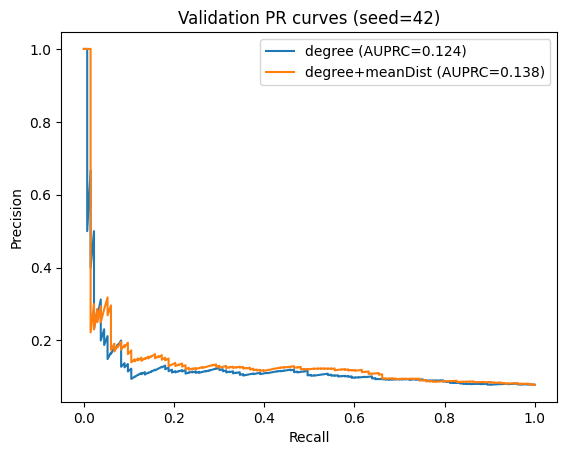

In [19]:
import matplotlib.pyplot as plt

# re-train once on seed 42 to plot PR curves (degree vs degree_meandist)
seed = 42
train_set, val_set, test_set = split_dataset(dataset_deg, seed=seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_for_curve(ds, extra_feats, seed=42, epochs=10):
    train_set, val_set, _ = split_dataset(ds, seed=seed)
    model = SAGE_NodeClassifier(extra_feats=extra_feats).to(device)
    loader = DataLoader(train_set, batch_size=4, shuffle=True)
    pw = pos_weight_from_train(train_set).to(device)
    crit = nn.BCEWithLogitsLoss(pos_weight=pw)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    for _ in range(epochs):
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            loss = crit(logits, batch.y.float())
            opt.zero_grad(); loss.backward(); opt.step()
    return model

m_deg = train_for_curve(dataset_deg, extra_feats=1, seed=seed)
m_dm  = train_for_curve(dataset_dm,  extra_feats=2, seed=seed)

val_loader_deg = DataLoader(split_dataset(dataset_deg, seed=seed)[1], batch_size=4, shuffle=False)
val_loader_dm  = DataLoader(split_dataset(dataset_dm,  seed=seed)[1], batch_size=4, shuffle=False)

p_deg, y_deg = collect_probs_and_labels(m_deg, val_loader_deg, device)
p_dm,  y_dm  = collect_probs_and_labels(m_dm,  val_loader_dm,  device)

prec1, rec1, _ = precision_recall_curve(y_deg, p_deg)
prec2, rec2, _ = precision_recall_curve(y_dm,  p_dm)

ap1 = average_precision_score(y_deg, p_deg)
ap2 = average_precision_score(y_dm,  p_dm)

plt.figure()
plt.plot(rec1, prec1, label=f"degree (AUPRC={ap1:.3f})")
plt.plot(rec2, prec2, label=f"degree+meanDist (AUPRC={ap2:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Validation PR curves (seed=42)")
plt.legend()
plt.show()
